In [0]:
 import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xml.etree import ElementTree

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [0]:
def getDataFrame(filename):
  dataset=[]
  tree = ElementTree.parse(filename)
  root = tree.getroot()

  for book in root.findall('book'):
      for metadata in book.find('metadata'):
          x=metadata
          break
      a=[]
      if(x.find('d3')!=None):
          a.append(x.find('d3').text)
      if(x.find('d2')!=None):
          a.append(x.find('d2').text)
      if(x.find('d1')!=None):
          a.append(x.find('d1').text)
      if(x.find('d0')!=None):
          a.append(x.find('d0').text)

      if len(a) != 0:        
        dataset.append([book.find('title').text,a,book.find('body').text])
  return dataset  
  
dataset = getDataFrame('./BlurbGenreCollection_EN_train.xml')
dataset2 = getDataFrame('./BlurbGenreCollection_EN_test.xml')
dataset = dataset + dataset2

In [0]:
df=pd.DataFrame(dataset,columns=['Name','Genres','Summary'])

In [115]:
df

,Name,Genres,Summary
0,"The New York Times Daily Crossword Puzzles: Thursday, Volume 1","[Games, Nonfiction]","Monday’s Crosswords Do with EaseTuesday’s Crosswords Not a BreezeWednesday’s Crosswords Harder StillThursday’s Crosswords Take Real SkillFriday’s Crosswords — You’ve Come This Far…Saturday’s Crosswords — You’re a Star!For millions of people, the New York Times crossword puzzles are as essential ..."
1,Creatures of the Night (Second Edition),"[Graphic Novels and Manga, Fiction]","Two of literary comics modern masters present a pair of magical and disturbing stories of strange creatures who are not quite what they seem! In The Price, a mysterious feline engages in a nightly conflict with an unseen, vicious foe. The Daughter of Owls recounts an eerie tale of a beautiful or..."
2,Cornelia and the Audacious Escapades of the Somerset Sisters,"[Children’s Middle Grade Books, Children’s Books]","Eleven-year-old Cornelia is the daughter of two world-famous pianists—a legacy that should feel fabulous, but instead feels just plain lonely. She surrounds herself with dictionaries and other books to isolate herself from the outside world. But when a glamorous neighbor named Virginia Somerset ..."
3,The Alchemist's Daughter,"[Historical Fiction, Fiction]","During the English Age of Reason, a woman cloistered since birth learns that knowledge is no substitute for experience.Raised by her father in near isolation in the English countryside, Emilie Selden is trained as a brilliant natural philosopher and alchemist. In the spring of 1725, father and d..."
4,Dangerous Boy,"[Teen and Young Adult Mystery and Suspense, Teen and Young Adult]","A modern-day retelling of The Strange Case of Dr. Jekyll and Mr. Hyde with a chilling twist Harper has never been worried about falling in love, something she is skeptical even exists. But everything changes when Logan moves to town, and to Harper’s shock, the two tumble into an intense romance...."
...,...,...,...
77104,Cathedral of the Sea,"[Romance, Fiction]","An unforgettable fresco of a golden age in fourteenth-century Barcelona, Cathedral of the Sea is a thrilling historical novel of friendship and revenge, plague and hope, love and war. Arnau Estanyol arrives in Barcelona to find a city dominated by the construction of the city’s great pride—the..."
77105,Understanding the Messages of Your Body,"[Alternative Therapies, Health and Fitness, Nonfiction]","Fears, anxieties, traumas, and physical and emotional shocks imprint on the body and remain dormant in its vast memory store until they are roused by an event or encounter. They may manifest in a different form or place—a fearful incident may transform itself into a stomachache or a headache, or..."
77106,Knockout,"[Alternative Therapies, Health and Fitness, Nonfiction]","In Knockout, Suzanne Somers interviews doctors who are successfully using the most innovative cancer treatments—treatments that build up the body rather than tear it down. Somers herself has stared cancer in the face, and a decade later she has conquered her fear and has emerged confident with t..."
77107,The End of the Suburbs,"[Domestic Politics, Politics, Nonfiction]","“The government in the past created one American Dream at the expense of almost all others: the dream of a house, a lawn, a picket fence, two children, and a car. But there is no single American Dream anymore.”For nearly 70 years, the suburbs were as American as apple pie. As the middle class ba..."


In [116]:
all_genres = sum(df["Genres"],[])
print("Total unique genres:", len(set(all_genres)))

Total unique genres: 139


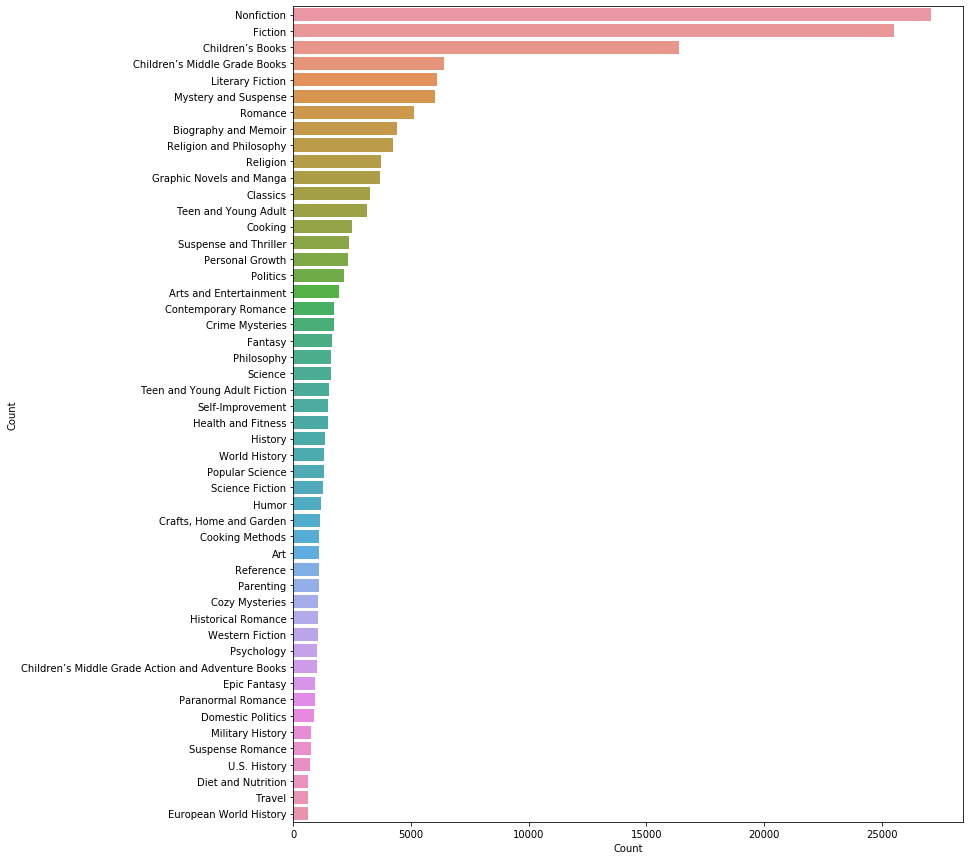

In [117]:
all_genres = nltk.FreqDist(all_genres) 
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [0]:
def clean_text(text):
    text = re.sub("\'", "", text) 
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = ' '.join(text.split()) 
    text = text.lower() 
    return text

In [0]:
df['Summary'] = df['Summary'].apply(lambda x: clean_text(x))

In [0]:
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df['Summary'] = df['Summary'].apply(lambda x: remove_stopwords(x))

In [121]:
df.head()

,Name,Genres,Summary
0,"The New York Times Daily Crossword Puzzles: Thursday, Volume 1","[Games, Nonfiction]",monday crosswords easetuesday crosswords breezewednesday crosswords harder stillthursday crosswords take real skillfriday crosswords come far saturday crosswords star millions people new york times crossword puzzles essential day first cup coffee morning first time ever premier puzzles available...
1,Creatures of the Night (Second Edition),"[Graphic Novels and Manga, Fiction]",two literary comics modern masters present pair magical disturbing stories strange creatures quite seem price mysterious feline engages nightly conflict unseen vicious foe daughter owls recounts eerie tale beautiful orphan girl found clutching owl pellet would wrong would face bizarre unforeseen...
2,Cornelia and the Audacious Escapades of the Somerset Sisters,"[Children’s Middle Grade Books, Children’s Books]",eleven year old cornelia daughter two world famous pianists legacy feel fabulous instead feels plain lonely surrounds dictionaries books isolate outside world glamorous neighbor named virginia somerset moves next door servant patel mischievous french bulldog named mister kinyatta cornelia discov...
3,The Alchemist's Daughter,"[Historical Fiction, Fiction]",english age reason woman cloistered since birth learns knowledge substitute experience raised father near isolation english countryside emilie selden trained brilliant natural philosopher alchemist spring father daughter embark upon daring alchemical experiment date attempting breathe life dead ...
4,Dangerous Boy,"[Teen and Young Adult Mystery and Suspense, Teen and Young Adult]",modern day retelling strange case dr jekyll mr hyde chilling twist harper never worried falling love something skeptical even exists everything changes logan moves town harper shock two tumble intense romance everything never thought wanted meets logan twin brother caleb expelled last school tru...


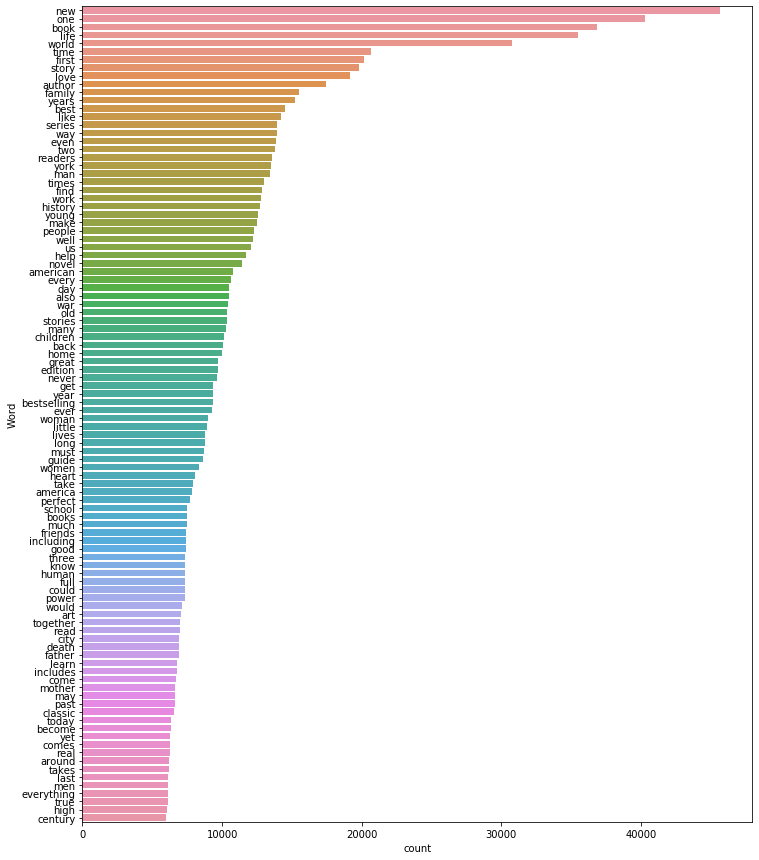

In [122]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
freq_words(df['Summary'], 100)

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
#from sklearn import preprocessing

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['Genres'])

# transform target variable
y = multilabel_binarizer.transform(df['Genres'])

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain, xval, ytrain, yval = train_test_split(df['Summary'], y, test_size=0.2, random_state=9)
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [0]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [0]:
import math
lr = LogisticRegression(max_iter=math.inf)
clf = OneVsRestClassifier(lr)

In [127]:
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=inf,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [0]:
y_pred = clf.predict(xval_tfidf)

In [129]:
f1_score(yval, y_pred, average="micro")
#clf.score(yval, y_pred)

0.657663414212935

In [0]:
y_pred_prob = clf.predict_proba(xval_tfidf)
t = 0.2505 # threshold value 0.2505 -> 0.7110468896756014
y_pred_new = (y_pred_prob >= t).astype(int)

In [131]:
f1_score(yval, y_pred_new, average="micro")

0.7110468896756014

In [0]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    #q_pred = clf.predict(q_vec)

    q_pred_prob = clf.predict_proba(q_vec)
    t = 0.2505 # threshold value 0.2505 -> 0.7110468896756014
    q_pred_new = (q_pred_prob >= t).astype(int)

    return multilabel_binarizer.inverse_transform(q_pred_new)

In [133]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Book: ", df['Name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",df['Genres'][k], "\n")

Book:  The American Revolution of 1800 
Predicted genre:  [('Domestic Politics', 'Nonfiction', 'Politics')]
Actual genre:  ['Colonial/Revolutionary Period', 'Domestic Politics', 'Politics', 'Nonfiction'] 

Book:  A Man Lies Dreaming 
Predicted genre:  [('Fiction', 'Literary Fiction', 'Mystery and Suspense', 'Suspense and Thriller')]
Actual genre:  ['Suspense and Thriller', 'Mystery and Suspense', 'Fiction'] 

Book:  A Man's Head 
Predicted genre:  [('Crime Mysteries', 'Fiction', 'Mystery and Suspense')]
Actual genre:  ['Crime Mysteries', 'Mystery and Suspense', 'Fiction'] 

Book:  The Toronto Maple Leaf Hockey Club 
Predicted genre:  [('Nonfiction', 'Sports')]
Actual genre:  ['Sports', 'Nonfiction'] 

Book:  The Bay of Foxes 
Predicted genre:  [('Fiction', 'Literary Fiction', 'Romance')]
Actual genre:  ['Literary Fiction', 'Fiction'] 

